<p><font size="6"><b>CASE - Bacterial resistance experiment</b></font></p>

> *© 2025, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In this case study, we will make use of the open data, affiliated to the following [journal article](http://rsbl.royalsocietypublishing.org/content/12/5/20160064):

>Arias-Sánchez FI, Hall A (2016) Effects of antibiotic resistance alleles on bacterial evolutionary responses to viral parasites. Biology Letters 12(5): 20160064. https://doi.org/10.1098/rsbl.2016.0064

<img src="../img/bacteriophage.jpeg">

Check the full paper on the [web version](http://rsbl.royalsocietypublishing.org/content/12/5/20160064). The study handles:
> Antibiotic resistance has wide-ranging effects on bacterial phenotypes and evolution. However, the influence of antibiotic resistance on bacterial responses to parasitic viruses remains unclear, despite the ubiquity of such viruses in nature and current interest in therapeutic applications. We experimentally investigated this by exposing various Escherichia coli genotypes, including eight antibiotic-resistant genotypes and a mutator, to different viruses (lytic bacteriophages). Across 960 populations, we measured changes in population density and sensitivity to viruses, and tested whether variation among bacterial genotypes was explained by their relative growth in the absence of parasites, or mutation rate towards phage resistance measured by fluctuation tests for each phage

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reading and processing the data

The data for this use case contains the evolution of different bacteria populations when combined with different phage treatments (viruses). The evolution of the bacterial population is measured by using the __optical density__ (OD) at 3 moments during the experiment: at the start (0h), after 20h and at the end (72h).

The data is available on [Dryad](http://www.datadryad.org/resource/doi:10.5061/dryad.90qb7.3), a general purpose data repository providing all kinds of data sets linked to journal papers. The downloaded data is available in this repository in the `data` folder as an excel-file called `Dryad_Arias_Hall_v3.xlsx`.

For the exercises, two sheets of the excel file will be used:
* `Main experiment`:


| Variable name | Description |
|---------------:|:-------------|
|**AB_r** |	Antibiotic resistance |
|**Bacterial_genotype** | Bacterial genotype |
|**Phage_t** |	Phage treatment |
|**OD_0h** |	Optical density at the start of the experiment (0h) |
|**OD_20h**	| Optical density after 20h |
|**OD_72h**	| Optical density at the end of the experiment (72h) |
|**Survival_72h** |	Population survival at 72h (1=survived, 0=extinct) |
|**PhageR_72h**	| Bacterial sensitivity to the phage they were exposed to (0=no bacterial growth, 1= colony formation in the presence of phage) |

* `Falcor`: we focus on a subset of the columns:

| Variable name | Description |
|---------------:|:-------------|
| **Phage**  | Bacteriophage used in the fluctuation test (T4, T7 and lambda) |
| **Bacterial_genotype** | Bacterial genotype. |
| **log10 Mc** |	Log 10 of corrected mutation rate |
| **log10 UBc** |	Log 10 of corrected upper bound |
| **log10 LBc** |	Log 10 of corrected lower bound |

Reading the `main experiment` data set from the corresponding sheet:

In [2]:
main_experiment = pd.read_excel("data/Dryad_Arias_Hall_v3.xlsx",
                                sheet_name="Main experiment")
main_experiment = main_experiment.drop(columns=["AB_r", "Survival_72h", "PhageR_72h"])  # focus on specific subset for this use case)

Read the `Falcor` data and subset the columns of interest:

In [3]:
falcor = pd.read_excel("data/Dryad_Arias_Hall_v3.xlsx", sheet_name="Falcor",
                       skiprows=1)
falcor = falcor[["Phage", "Bacterial_genotype", "log10 Mc", "log10 UBc", "log10 LBc"]]
falcor.head()

,Phage,Bacterial_genotype,log10 Mc,log10 UBc,log10 LBc
0,T7,RP4,-6.908090,-6.766699,-7.086027
1,T7,RSF1010,-6.839080,-6.709209,-6.999176
2,T7,K43N,-7.072899,-6.933264,-7.248105
3,T7,S512F,-7.058820,-6.902430,-7.261299
4,T7,D516G,-6.920474,-6.722230,-7.199283


## Tidy the `main_experiment` data

*(If you're wondering what `tidy` data representations are, check again the `pandas_08_reshaping_data.ipynb` notebook)*

Actually, the columns `OD_0h`, `OD_20h` and `OD_72h` are representing the same variable (i.e. `optical_density`) and the column names itself represent a variable, i.e. `experiment_time_h`. Hence, it is stored in the table as *short* format and we could *tidy* these columns by converting them to 2 columns: `experiment_time_h` and `optical_density`.

Before making any changes to the data, we will add an identifier column for each of the current rows to make sure we keep the connection in between the entries of a row when converting from wide to long format.

In [4]:
main_experiment["experiment_ID"] = ["ID_" + str(idx) for idx in range(len(main_experiment))]
main_experiment

,Bacterial_genotype,Phage_t,OD_0h,OD_20h,OD_72h,experiment_ID
0,D516G,C_noPhage,0.1971,0.5960,0.6900,ID_0
1,D516G,C_noPhage,0.1593,0.5702,0.6989,ID_1
2,D516G,C_noPhage,0.0926,0.6613,0.6474,ID_2
3,D516G,C_noPhage,0.1482,0.6465,0.7045,ID_3
4,D516G,C_noPhage,0.0978,0.6752,0.6700,ID_4
...,...,...,...,...,...,...
949,MUT,T7,0.0417,0.0402,0.3179,ID_949
950,MUT,T7,0.0789,0.0276,0.3601,ID_950
951,MUT,T7,0.0875,0.0216,0.3709,ID_951
952,MUT,T7,0.0755,0.0418,0.3628,ID_952


<div class="alert alert-success">

**EXERCISE**:

Convert the columns `OD_0h`, `OD_20h` and `OD_72h` to a long format with the values stored in a column `optical_density` and the time in the experiment as `experiment_time_h`. Save the variable as `tidy_experiment`.

<details><summary>Hints</summary>

- Have a look at `pandas_08_reshaping_data.ipynb` to find out the required function.
- Remember to check the documentation of a function using the `SHIFT` + `TAB` keystroke combination when the cursor is on the function of interest.

</details>

</div>

In [5]:
tidy_experiment = main_experiment.melt(id_vars=['Bacterial_genotype', 'Phage_t', 'experiment_ID'],
                                       value_vars=['OD_0h', 'OD_20h', 'OD_72h'],
                                       var_name='experiment_time_h',
                                       value_name='optical_density', )
tidy_experiment

,Bacterial_genotype,Phage_t,experiment_ID,experiment_time_h,optical_density
0,D516G,C_noPhage,ID_0,OD_0h,0.1971
1,D516G,C_noPhage,ID_1,OD_0h,0.1593
2,D516G,C_noPhage,ID_2,OD_0h,0.0926
3,D516G,C_noPhage,ID_3,OD_0h,0.1482
4,D516G,C_noPhage,ID_4,OD_0h,0.0978
...,...,...,...,...,...
2857,MUT,T7,ID_949,OD_72h,0.3179
2858,MUT,T7,ID_950,OD_72h,0.3601
2859,MUT,T7,ID_951,OD_72h,0.3709
2860,MUT,T7,ID_952,OD_72h,0.3628


## Visual data exploration

In [6]:
tidy_experiment.head()

,Bacterial_genotype,Phage_t,experiment_ID,experiment_time_h,optical_density
0,D516G,C_noPhage,ID_0,OD_0h,0.1971
1,D516G,C_noPhage,ID_1,OD_0h,0.1593
2,D516G,C_noPhage,ID_2,OD_0h,0.0926
3,D516G,C_noPhage,ID_3,OD_0h,0.1482
4,D516G,C_noPhage,ID_4,OD_0h,0.0978


<div class="alert alert-success">

**EXERCISE**:

* Make a histogram using the [Seaborn package](https://seaborn.pydata.org/index.html) to visualize the distribution of the `optical_density`
* Change the overall theme to any of the available Seaborn themes
* Change the border color of the bars to `white` and the fill color of the bars to `grey`
    
Using Matplotlib, further adjust the histogram:
    
- Add a Figure title "Optical density distribution".
- Overwrite the y-axis label to "Frequency".

<details><summary>Hints</summary>

- See https://seaborn.pydata.org/tutorial/distributions.html#plotting-univariate-histograms.
- There are five preset seaborn themes: `darkgrid`, `whitegrid`, `dark`, `white`, and `ticks`.
- Make sure to set the theme before creating the graph.
- Seaborn relies on Matplotlib to plot the individual bars, so the available parameters (`**kwargs`) to adjust the bars that can be passed (e.g. `color` and `edgecolor`) are enlisted in the [matplotlib.axes.Axes.bar](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.axes.Axes.bar.html) documentation.
- The output of a Seaborn plot is an object from which the Matplotlib `Figure` and `Axes` can be accessed, respectively `snsplot.fig` and `snsplot.axes`. Note that the `axes` are always returned as a 2x2 array of Axes (also if it only contains a single element).

</details>

</div>

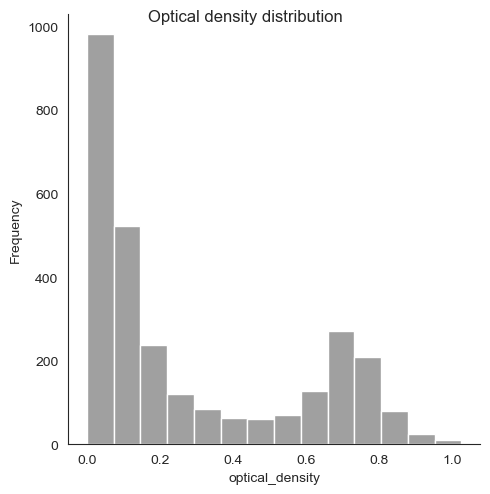

In [7]:
sns.set_style("white")
histplot = sns.displot(data=tidy_experiment, x="optical_density",
                       color='grey', edgecolor='white')

histplot.fig.suptitle("Optical density distribution")
histplot.axes[0][0].set_ylabel("Frequency");

<div class="alert alert-success">

**EXERCISE**

Use a Seaborn `violin plot` to check the distribution of the `optical_density` in each of the experiment time phases (`experiment_time_h` in the x-axis).

<details><summary>Hints</summary>

- See https://seaborn.pydata.org/tutorial/categorical.html#violinplots.
- Whereas the previous exercise focuses on the distribution of data (`distplot`), this exercise focuses on distributions _for each category of..._ and needs the categorical functions of Seaborn (`catplot`).

</details>

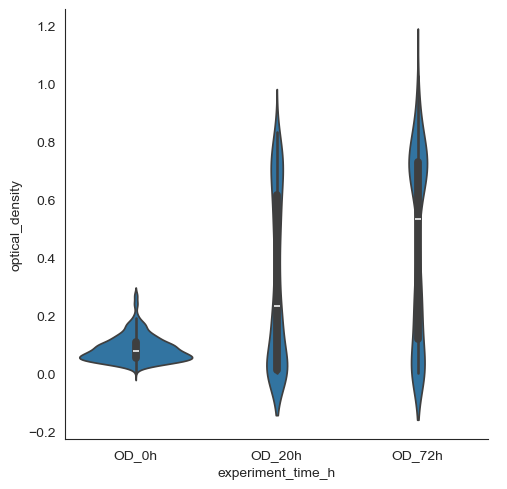

In [8]:
sns.catplot(data=tidy_experiment, x="experiment_time_h",
            y="optical_density", kind="violin")

<div class="alert alert-success">

**EXERCISE**

For each `Phage_t` in an individual subplot, use a `violin plot` to check the distribution of the `optical_density` in each of the experiment time phases (`experiment_time_h`)

<details><summary>Hints</summary>

- The technical term for splitting in subplots using a categorical variable is 'faceting' (or sometimes also 'small multiple'), see https://seaborn.pydata.org/tutorial/categorical.html#showing-multiple-relationships-with-facets
- You want to wrap the number of columns on 2 subplots, look for a function argument in the documentation of the `catplot` function.

</details>

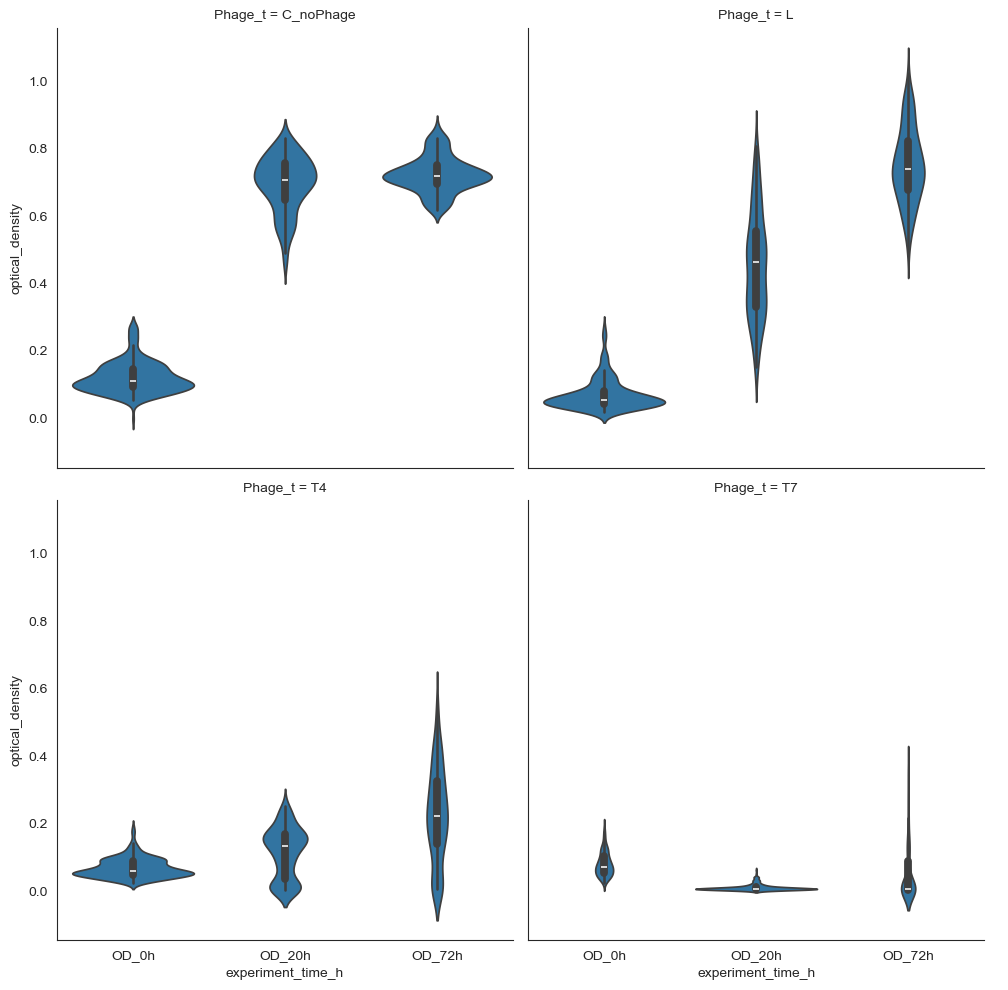

In [9]:
sns.catplot(data=tidy_experiment, x="experiment_time_h", y="optical_density",
            col="Phage_t", col_wrap=2, kind="violin")

<div class="alert alert-success">

**EXERCISE**

Create a summary table of the __average__ `optical_density` with the `Bacterial_genotype` in the rows and the `experiment_time_h` in the columns

<details><summary>Hints</summary>

- No Seaborn required here, rely on Pandas `pivot_table()` function to reshape tables.

</details>

In [10]:
pd.pivot_table(tidy_experiment, values='optical_density',
               index='Bacterial_genotype',
               columns='experiment_time_h',
               aggfunc='mean')

experiment_time_h,OD_0h,OD_20h,OD_72h
Bacterial_genotype,,,
D516G,0.081090,0.308745,0.422481
D87G,0.094826,0.358149,0.435589
K43N,0.073319,0.229284,0.360857
K88R,0.087895,0.349078,0.441870
MUT,0.086279,0.370074,0.549770
RP4,0.100410,0.294452,0.438770
RSF1010,0.086731,0.338346,0.464583
S512F,0.059865,0.269255,0.413397
S83L,0.099519,0.352234,0.438004


Advanced/optional solution:

In [11]:
# advanced/optional solution
tidy_experiment.groupby(['Bacterial_genotype', 'experiment_time_h'])['optical_density'].mean().unstack()

experiment_time_h,OD_0h,OD_20h,OD_72h
Bacterial_genotype,,,
D516G,0.081090,0.308745,0.422481
D87G,0.094826,0.358149,0.435589
K43N,0.073319,0.229284,0.360857
K88R,0.087895,0.349078,0.441870
MUT,0.086279,0.370074,0.549770
RP4,0.100410,0.294452,0.438770
RSF1010,0.086731,0.338346,0.464583
S512F,0.059865,0.269255,0.413397
S83L,0.099519,0.352234,0.438004


<div class="alert alert-success">

**EXERCISE**

- Calculate for each combination of `Bacterial_genotype`, `Phage_t` and `experiment_time_h` the <i>mean</i> `optical_density` and store the result as a DataFrame called `density_mean` (tip: use `reset_index()` to convert the resulting Series to a DataFrame).
- Based on `density_mean`, make a _barplot_ of the mean optical density for each `Bacterial_genotype`, with for each `Bacterial_genotype` an individual bar and with each `Phage_t` in a different color/hue (i.e. grouped bar chart).
- Use the `experiment_time_h` to split into subplots. As we mainly want to compare the values within each subplot, make sure the scales in each of the subplots are adapted to its own data range, and put the subplots on different rows.
- Adjust the size and aspect ratio of the Figure to your own preference.
- Change the color scale of the bars to another Seaborn palette.

<details><summary>Hints</summary>


- _Calculate for each combination of..._ should remind you to the `groupby` functionality of Pandas to calculate statistics for each group.
- The exercise is still using the `catplot` function of Seaborn with `bar`s. Variables are used to vary the `hue` and `row`.
- Each subplot its own range is the same as not sharing axes (`sharey` argument).
- Seaborn in fact has six variations of matplotlib’s palette, called `deep`, `muted`, `pastel`, `bright`, `dark`, and `colorblind`. See https://seaborn.pydata.org/tutorial/color_palettes.html#qualitative-color-palettes

</details>

In [12]:
density_mean = (tidy_experiment
                .groupby(['Bacterial_genotype','Phage_t', 'experiment_time_h'])['optical_density']
                .mean().reset_index())

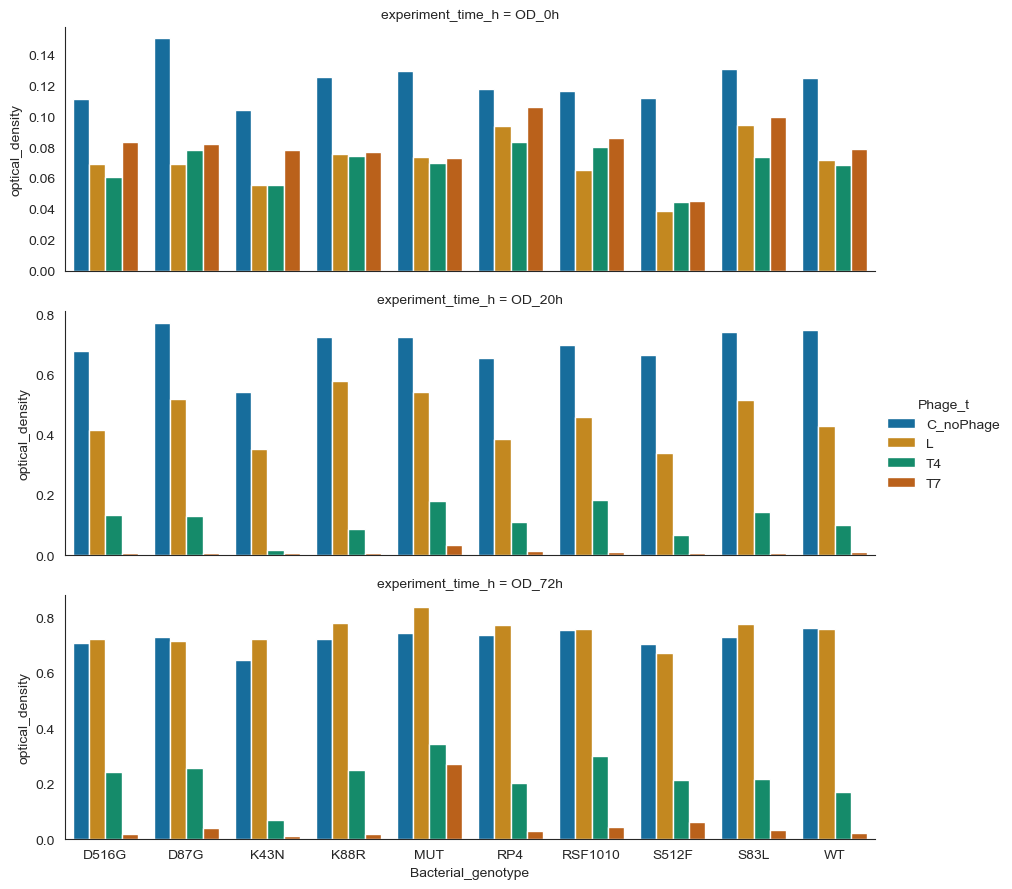

In [13]:
sns.catplot(data=density_mean, kind="bar",
            x='Bacterial_genotype',
            y='optical_density',
            hue='Phage_t',
            row="experiment_time_h",
            sharey=False,
            aspect=3, height=3,
            palette="colorblind")

## (Optional) Reproduce chart of the original paper

Check Figure 2 of the original journal paper in the 'correction' part of the <a href="http://rsbl.royalsocietypublishing.org/content/roybiolett/12/5/20160064.full.pdf">pdf</a>:

<img src="https://royalsocietypublishing.org/cms/attachment/eb511c57-4167-4575-b8b3-93fbcf728572/rsbl20160064f02.jpg" width="500">

In [14]:
falcor.head()

,Phage,Bacterial_genotype,log10 Mc,log10 UBc,log10 LBc
0,T7,RP4,-6.908090,-6.766699,-7.086027
1,T7,RSF1010,-6.839080,-6.709209,-6.999176
2,T7,K43N,-7.072899,-6.933264,-7.248105
3,T7,S512F,-7.058820,-6.902430,-7.261299
4,T7,D516G,-6.920474,-6.722230,-7.199283


<div class="alert alert-success">

**EXERCISE**

We will first reproduce 'Figure 2' without the error bars:

- Make sure the `WT(2)` and `MUT(2)` categories are used as respectively `WT` and `MUT` by adjusting them with Pandas first.
- Use the __falcor__ data and the Seaborn package. The 'log10 mutation rate' on the figure corresponds to the `log10 Mc` column.

<details><summary>Hints</summary>

- To replace values using a mapping (dictionary with the keys the current values and the values the new values), use the Pandas `replace` method.
- This is another example of a `catplot`, using `point`s to represent the data.
- To avoid that the individual points get connected with a line, you can pass `linestyle="none"`.
- Seaborn provides the `row_order` and `order` options to provide a custom order of respectively the subplots and categories.
- One combination appears multiple times, so make sure to not yet use confidence intervals by setting `errorbar` to `None`.
</details>

In [15]:
falcor["Bacterial_genotype"] = falcor["Bacterial_genotype"].replace({'WT(2)': 'WT',
                                                                     'MUT(2)': 'MUT'})
falcor.head()

,Phage,Bacterial_genotype,log10 Mc,log10 UBc,log10 LBc
0,T7,RP4,-6.908090,-6.766699,-7.086027
1,T7,RSF1010,-6.839080,-6.709209,-6.999176
2,T7,K43N,-7.072899,-6.933264,-7.248105
3,T7,S512F,-7.058820,-6.902430,-7.261299
4,T7,D516G,-6.920474,-6.722230,-7.199283


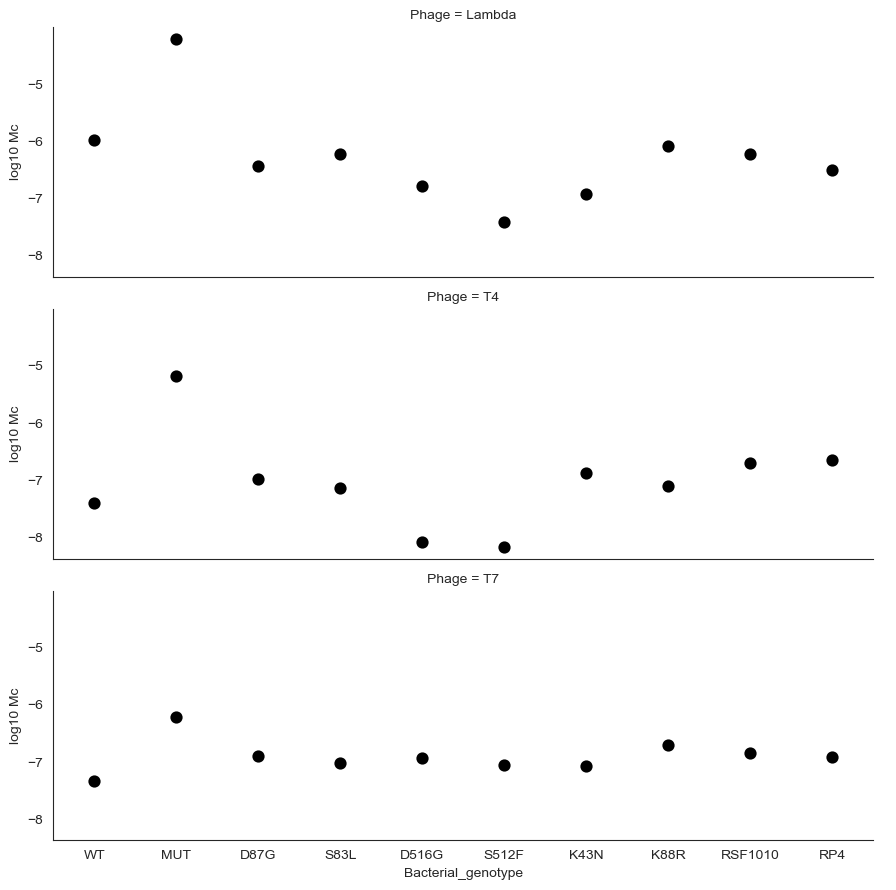

In [16]:
sns.catplot(data=falcor, kind="point",
            x='Bacterial_genotype',
            y='log10 Mc',
            row="Phage",
            linestyle="none",
            errorbar=None,
            row_order=["Lambda", "T4", "T7"],
            order=['WT', 'MUT', 'D87G', 'S83L', 'D516G', 'S512F', 'K43N', 'K88R', 'RSF1010', 'RP4'],
            aspect=3, height=3,
            color="black")

Seaborn supports confidence intervals by different estimators when multiple values are combined (see [this example](https://seaborn.pydata.org/examples/pointplot_anova.html)). In this particular case, the error estimates are already provided and are not symmetrical. Hence, we need to find a method to use the lower `log10 LBc` and upper `log10 UBc` confidence intervals.

Stackoverflow can help you with this, see [this thread](https://stackoverflow.com/questions/38385099/adding-simple-error-bars-to-seaborn-factorplot) to solve the following exercise.

<div class="alert alert-success">

**EXERCISE**

Reproduce 'Figure 2' with the error bars using the information from [this Stackoverflow thread](https://stackoverflow.com/questions/38385099/adding-simple-error-bars-to-seaborn-factorplot). You do not have to adjust the order of the categories in the x-axis.

<details><summary>Hints</summary>

- Do not use the `catplot` function, but first create the layout of the graph by `FacetGrid` on the `Phage` variable.
- Next, map a custom `errorbar` function to the FactgGrid as the example from Stackoverflow.
- Adjust/Simplify the `errorbar` custom function for your purpose.
- Matplotlib uses the `capsize` to draw upper and lower lines of the intervals.

</details>

In [17]:
falcor["Bacterial_genotype"] = falcor["Bacterial_genotype"].replace({'WT(2)': 'WT',
                                                                     'MUT(2)': 'MUT'})

In [18]:
def errorbar(x, y, low, high, **kws):
    """Utility function to link falcor data representation with the errorbar representation"""
    plt.errorbar(x, y, (y - low, high - y), capsize=3, fmt="o", color="black", ms=4)

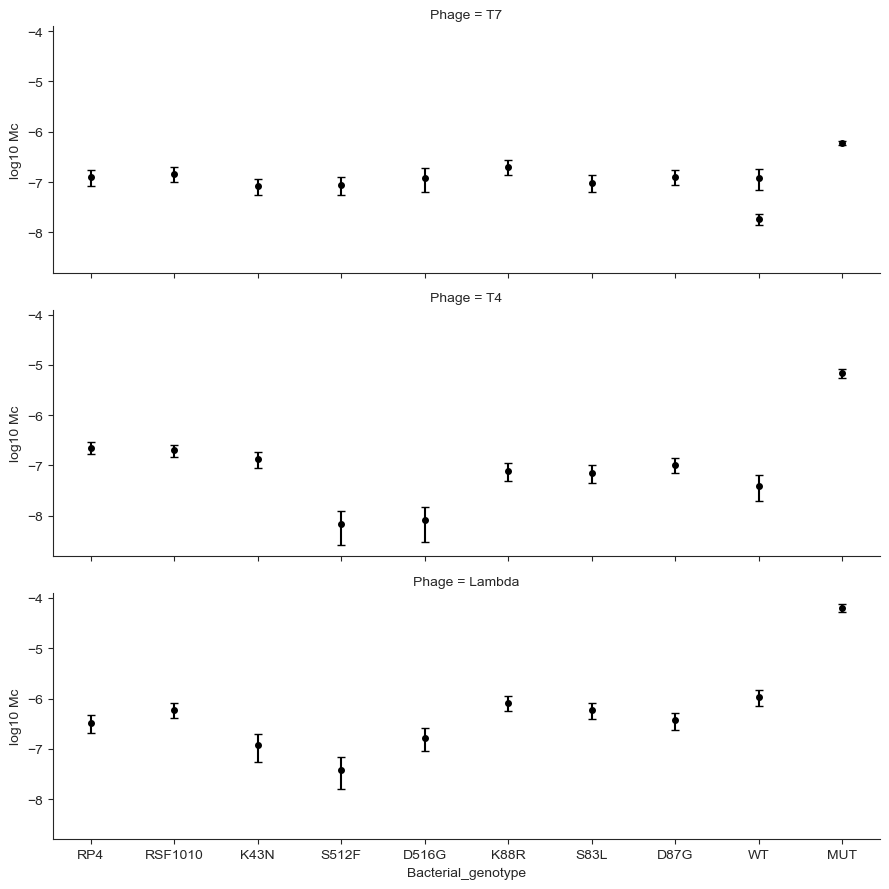

In [19]:
sns.set_style("ticks")
g = sns.FacetGrid(data=falcor, row="Phage", aspect=3, height=3)
g.map(errorbar,
      "Bacterial_genotype", "log10 Mc",
      "log10 LBc", "log10 UBc")